# Combinatorial library vs. ChEMBL

## Aims of this notebook

In this notebook we want to compare the combinatorial library to the ChEMBL 25 dataset.

## Table of contents

1. Combinatorial library data
2. Most similar ChEMBL ligands
3. Exact matches

In [6]:
from pathlib import Path

from chembl_webresource_client.new_client import new_client
import ijson
import matplotlib.pyplot as plt
import pandas as pd
import requests
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole

In [11]:
PATH_COMBINATORIAL_LIBRARY = Path('../data/combinatorial_library/combinatorial_library.json')
ACTIVITY_THRESHOLD = 500

## 1. Combinatorial library data

The combinatorial library comes as large JSON file. In order to access/filter ligands efficiently (time and memory), we use the `ijson` library:

> Ijson is an iterative JSON parser with standard Python iterator interfaces.

https://pypi.org/project/ijson/

For a detailed description on the kind of information linked to the combinatorial library, please take a look at the notebook `notebooks/4_1_combinatorial_library_properties.ipynb`.

## 2. Most similar ChEMBL ligands

In [12]:
def similarities_of_most_similar_chembl_ligands(path_json):

    # get object generator from json
    f = open(path_json, 'rb')
    objects = ijson.items(f, 'item')

    # filter objects
    objects_filtered = [o['chembl_most_similar'][1] for o in objects]
    
    return objects_filtered

In [13]:
similarities = similarities_of_most_similar_chembl_ligands(PATH_COMBINATORIAL_LIBRARY)

(array([ 4.,  0.,  2., 10.,  0., 24.,  8., 10.,  0.,  6.]),
 array([0.22 , 0.238, 0.256, 0.274, 0.292, 0.31 , 0.328, 0.346, 0.364,
        0.382, 0.4  ]),
 <a list of 10 Patch objects>)

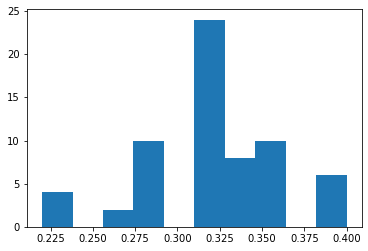

In [14]:
plt.hist(similarities)

## 3. Exact matches

### Get exact matches

In [15]:
def exact_chembl_matches(path_json):

    # get object generator from json
    f = open(path_json, 'rb')
    objects = ijson.items(f, 'item')

    # filter objects
    objects_filtered = [o for o in objects if o['chembl_exact'] != []]
    objects_filtered_df = pd.DataFrame(objects_filtered)
    
    print(f'Number of exact matches in ChEMBL ligands: {objects_filtered_df.shape[0]}')
    
    return objects_filtered_df

In [18]:
exact_matches = exact_chembl_matches(PATH_COMBINATORIAL_LIBRARY)
exact_matches.head()

Number of exact matches in ChEMBL ligands: 0


""


### Get ChEMBL IDs for exact matches

In [75]:
# temporary
f = open(PATH_COMBINATORIAL_LIBRARY, 'rb')
objects = ijson.items(f, 'item')
molecule_ids = [o['chembl_most_similar'][0] for o in objects]
molecule_ids[:3]

['CHEMBL405398', 'CHEMBL405398', 'CHEMBL264472']

### Get targets for exact matches

1. Get ChEMBL clients
2. Get compound ChEMBL IDs
3. TBA

In [116]:
def add_filtering_step(filtering, df, step_name):
    
    return filtering.append(
        pd.Series(
            [
                step_name,
                len(df.molecule_chembl_id.unique()),
                len(df.target_chembl_id.unique()),
                len(df.assay_chembl_id.unique()),
                df.shape[0]
            ],
            index=['filtering_step', 'molecules', 'targets', 'assays', 'activities']
        ),
        ignore_index=True
    )

In [117]:
# Initialize filtering table
filtering = pd.DataFrame(columns=['filtering_step', 'molecules', 'targets', 'assays', 'activities'])

#### 1. Get ChEMBL clients

In [118]:
similarity_client = new_client.similarity
molecule_client = new_client.molecule
activity_client = new_client.activity
target_client = new_client.target

#### 2. Get compound ChEMBL IDs

In [119]:
def get_molecules(molecule_ids):
    
    result = molecule_client.get(molecule_ids)
    
    molecules = pd.DataFrame(result)
    molecules = molecules[['molecule_chembl_id', 'molecule_structures', 'first_approval', 'atc_classifications']]
    molecules['smiles'] = molecules.molecule_structures.apply(lambda x: x['canonical_smiles'])
    molecules['inchi'] = molecules.molecule_structures.apply(lambda x: x['standard_inchi'])
    molecules.drop('molecule_structures', axis=1, inplace=True)
    
    print(f'Number of queries: {len(molecule_ids)}')
    print(f'Number of query results: {molecules.shape[0]}')
    
    return molecules

In [120]:
molecules = get_molecules(molecule_ids)

Number of queries: 64
Number of query results: 64


#### 3. Get measured activities for molecules

In [132]:
def get_activities(molecule_ids):
    
    activities = activity_client.filter(
        molecule_chembl_id__in=molecule_ids,
        type='IC50', 
        relation='=', 
        assay_type='B'
    ).only(
        'activity_id','assay_chembl_id', 'assay_description', 'assay_type', \
        'molecule_chembl_id', 'type', 'standard_units', 'relation', 'standard_value', \
        'target_chembl_id', 'target_organism', 'target_pref_name'
    )
    
    activities_df = pd.DataFrame.from_records(list(activities))
    activities_df = activities_df.astype({'standard_value': 'float'})
    
    print(f'Number of queries: {len(molecule_ids)}')
    print(f'Number of query results: {activities_df.shape[0]}')
    
    return activities_df

In [133]:
activities = get_activities(molecule_ids)

Number of queries: 64
Number of query results: 2


In [134]:
filtering = add_filtering_step(filtering, activities, 'ChEMBL bioactivity entries')

#### 4. Remove activities for non-human target organisms

In [135]:
activities = activities[activities.target_organism == 'Homo sapiens']

In [136]:
filtering = add_filtering_step(filtering, activities, 'Only human entries')

#### 5. Get activity distribution

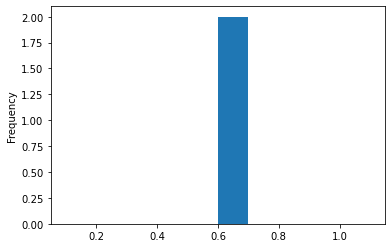

In [138]:
activities.standard_value.plot(kind='hist')

#### 5. Get tested targets (and assay types) per molecule

In [142]:
activities.groupby(
    ['molecule_chembl_id', 'target_chembl_id', 'target_pref_name']
).size()

molecule_chembl_id  target_chembl_id  target_pref_name    
CHEMBL266960        CHEMBL1827        Phosphodiesterase 5A    2
dtype: int64

In [2]:
bioact_df[
    ['molecule_chembl_id', 'target_chembl_id', 'target_pref_name', 'assay_chembl_id']
].groupby(
    ['molecule_chembl_id', 'target_chembl_id', 'target_pref_name']
).count()

NameError: name 'bioact_df' is not defined

#### 6. Get molecules that are "active" (<=500 nM) against at least one target

In [27]:
# Group bioactivity results by molecule ChEMBL ID
bioact_df_grouped = bioact_df[
    ['molecule_chembl_id', 'target_chembl_id', 'target_pref_name', 'assay_chembl_id', 'assay_description', 'value']
].groupby(
    ['molecule_chembl_id']
)

In [28]:
# Which molecules are "active" against at least one target
bioact_df_active = bioact_df_grouped.apply(
    lambda x: x if (sum(x.value <= ACTIVITY_THRESHOLD) > 0) else None
).dropna()

In [29]:
bioact_df_active.sort_values(by='molecule_chembl_id', inplace=True)

In [30]:
bioact_df_active.shape

(27, 6)

In [31]:
filtering = add_filtering_step(filtering, bioact_df_active, 'Only "active" entries')
filtering

,filtering_step,molecules,targets,assays,values
0,ChEMBL bioactivity entries,33,46,65,69
1,Only human entries,24,33,46,48
2,"Only ""active"" entries",11,17,25,27


In [3]:
bioact_df_active[
    ['molecule_chembl_id', 'target_chembl_id', 'target_pref_name', 'assay_chembl_id', 'assay_description', 'value']
].groupby(
    ['molecule_chembl_id', 'target_chembl_id', 'target_pref_name', 'assay_chembl_id', 'assay_description', 'value']
).count()

NameError: name 'bioact_df_active' is not defined

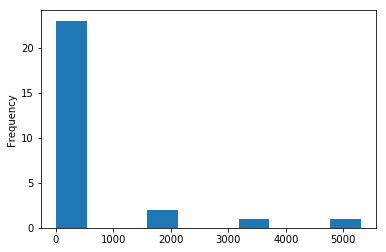

In [33]:
bioact_df_active.value.plot(kind='hist')

In [4]:
bioact_df_active[
    ['target_chembl_id', 'target_pref_name', 'assay_chembl_id', 'assay_description', 'molecule_chembl_id']
].groupby(
    ['target_chembl_id', 'target_pref_name', 'assay_chembl_id', 'assay_description']
).count()

NameError: name 'bioact_df_active' is not defined

#### 7. Get ChEMBL target details: Protein target classification (PTC)

In order to access the protein target classification, we follow the instructions given here:

https://github.com/chembl/chembl_webservices_2/issues/95

In [35]:
target_chembl_ids = list(bioact_df_active.target_chembl_id.unique())
print(len(target_chembl_ids))
target_chembl_ids

17


['CHEMBL5393',
 'CHEMBL3708265',
 'CHEMBL2147',
 'CHEMBL3883328',
 'CHEMBL5407',
 'CHEMBL4523',
 'CHEMBL5443',
 'CHEMBL3038477',
 'CHEMBL3038469',
 'CHEMBL3038467',
 'CHEMBL301',
 'CHEMBL308',
 'CHEMBL1075104',
 'CHEMBL1968',
 'CHEMBL2842',
 'CHEMBL4630',
 'CHEMBL5578']

### Define request functions for `target`, `target_components` and `protein_class` ChEMBL endpoints

In [36]:
def extract_component_id_from_target(target_chembl_id):
    """
    Go to `target` endpoint and extract `component_id`
    """
    
    target_url = f'https://www.ebi.ac.uk/chembl/api/data/target/{target_chembl_id}.json'
    #print(target_url)
    
    response = requests.get(target_url)
    response.raise_for_status()
    result = response.json()

    component_ids = [i['component_id'] for i in result['target_components']]
    return component_ids


In [37]:
def extract_protein_classification_id_from_target_components(component_id):
    """
    Go to `target_components` endpoint and extract `protein_classification_id`
    """
    
    target_components_url = f'https://www.ebi.ac.uk/chembl/api/data/target_component/{component_id}.json'
    #print(target_components_url)

    response = requests.get(target_components_url)
    response.raise_for_status()  # this line checks for potential errors
    result = response.json()

    protein_classification_ids = [i['protein_classification_id'] for i in result['protein_classifications']]

    return protein_classification_ids

In [38]:
def get_protein_target_classification_from_protein_class(protein_classification_id):
    """
    Go to `protein_class` endpoint and extract protein target classification.
    """

    protein_class_url = f'https://www.ebi.ac.uk/chembl/api/data/protein_class/{protein_classification_id}.json'
    #print(protein_class_url)

    response = requests.get(protein_class_url)
    response.raise_for_status()  # this line checks for potential errors
    result = response.json()

    return pd.Series(result)

In [39]:
def get_protein_target_classifications(target_chembl_ids):
    """
    Get protein target classifications for a list of target ChEMBL IDs (in the form of a DataFrame).
    """

    results = []

    for target_chembl_id in target_chembl_ids:
        #print(target_chembl_id)

        # Go to `target` endpoint and extract `component_id`
        component_ids = extract_component_id_from_target(target_chembl_id)
        
        if len(component_ids) != 1:
            print(f'{target_chembl_id}: {len(component_ids)} component IDs for target ChEMBL ID.')

        for component_id in component_ids:
            #print(component_id)

            # Go to `target_components` endpoint and extract `protein_classification_id`
            protein_classification_ids = extract_protein_classification_id_from_target_components(component_id)

            if len(protein_classification_ids) != 1:
                print(f'{target_chembl_id}: {len(protein_classification_ids)} protein classification IDs for target ChEMBL ID.\n')    
            
            for protein_classification_id in protein_classification_ids:
                #print(protein_classification_id)

                # Go to `protein_class` endpoint and extract protein target classification.
                protein_target_classification = get_protein_target_classification_from_protein_class(protein_classification_id)

                # Add ID details
                protein_target_classification['target_chembl_id'] = target_chembl_id
                protein_target_classification['component_id'] = component_id
                protein_target_classification['protein_classification_id'] = protein_classification_id

                results.append(protein_target_classification)
                
    return pd.DataFrame(results)

### Get PTC for target ChEMBL IDs

Check for each query, how many protein target classification entries are available!

In [40]:
len(target_chembl_ids)

17

In [41]:
protein_target_classifications = get_protein_target_classifications(target_chembl_ids)

CHEMBL3883328: 2 component IDs for target ChEMBL ID.
CHEMBL3038477: 2 component IDs for target ChEMBL ID.
CHEMBL3038469: 2 component IDs for target ChEMBL ID.
CHEMBL3038467: 2 component IDs for target ChEMBL ID.


In [42]:
protein_target_classifications.shape

(21, 12)

In [43]:
len(protein_target_classifications.target_chembl_id.unique())

17

### Look at protein target classifications

In [44]:
protein_target_classifications

,l1,l2,l3,l4,l5,l6,l7,l8,protein_class_id,target_chembl_id,component_id,protein_classification_id
0,Transporter,Primary active transporter,ATP-binding cassette,ABCG subfamily,None,None,None,None,750,CHEMBL5393,3688,750
1,Enzyme,None,None,None,None,None,None,None,1,CHEMBL3708265,10418,1
2,Enzyme,Kinase,Protein Kinase,CAMK protein kinase group,CAMK protein kinase PIM family,None,None,None,235,CHEMBL2147,489,235
3,Enzyme,Kinase,Protein kinase regulatory subunit,None,None,None,None,None,129,CHEMBL3883328,699,129
4,Enzyme,Kinase,Protein Kinase,Other protein kinase group,Other protein kinase CK2 family,None,None,None,252,CHEMBL3883328,2389,252
5,Enzyme,Kinase,Protein Kinase,CAMK protein kinase group,CAMK protein kinase PIM family,None,None,None,235,CHEMBL5407,3702,235
6,Enzyme,Kinase,Protein Kinase,CAMK protein kinase group,CAMK protein kinase PIM family,None,None,None,235,CHEMBL4523,2840,235
7,Enzyme,Kinase,Protein Kinase,Other protein kinase group,Other protein kinase CDC7 family,None,None,None,271,CHEMBL5443,5015,271
8,Enzyme,Kinase,Protein kinase regulatory subunit,None,None,None,None,None,129,CHEMBL3038477,699,129
9,Enzyme,Kinase,Protein Kinase,Other protein kinase group,Other protein kinase CK2 family,None,None,None,252,CHEMBL3038477,1946,252


### Per target ChEMBL ID, drop duplicated content (manually!)

Get indices that we want to drop - this is a manual step because we need to decide which entry per target ChEMBL ID we would like to keep/toss.

In [45]:
# Show target ChEMBL IDs with multiple PTCs
protein_target_classifications.groupby(
    by='target_chembl_id'
).apply(
    lambda x: x if (x.shape[0] > 1) else None
).dropna(
    how='all'
)

,l1,l2,l3,l4,l5,l6,l7,l8,protein_class_id,target_chembl_id,component_id,protein_classification_id
3,Enzyme,Kinase,Protein kinase regulatory subunit,None,None,None,None,None,129.0,CHEMBL3883328,699.0,129.0
4,Enzyme,Kinase,Protein Kinase,Other protein kinase group,Other protein kinase CK2 family,None,None,None,252.0,CHEMBL3883328,2389.0,252.0
8,Enzyme,Kinase,Protein kinase regulatory subunit,None,None,None,None,None,129.0,CHEMBL3038477,699.0,129.0
9,Enzyme,Kinase,Protein Kinase,Other protein kinase group,Other protein kinase CK2 family,None,None,None,252.0,CHEMBL3038477,1946.0,252.0
10,Enzyme,Kinase,Protein Kinase,CMGC protein kinase group,CMGC protein kinase CDK family,CMGC protein kinase CDC2 subfamily,None,None,323.0,CHEMBL3038469,36.0,323.0
11,Other cytosolic protein,None,None,None,None,None,None,None,8.0,CHEMBL3038469,918.0,8.0
12,Enzyme,Kinase,Protein Kinase,CMGC protein kinase group,CMGC protein kinase CDK family,CMGC protein kinase CDC2 subfamily,None,None,323.0,CHEMBL3038467,7.0,323.0
13,Other cytosolic protein,None,None,None,None,None,None,None,8.0,CHEMBL3038467,918.0,8.0


In [46]:
# Manual step!!
drop_class_ix = [3, 8, 11, 13]

In [47]:
protein_target_classifications.shape

(21, 12)

In [48]:
protein_target_classifications.drop(drop_class_ix, inplace=True)

In [49]:
protein_target_classifications.shape

(17, 12)

### Show enzyme group distribution

In [50]:
len(protein_target_classifications.l2)

17

In [51]:
protein_target_classifications.groupby(by='l2').size()

l2
Kinase                        13
Primary active transporter    1 
Protease                      1 
dtype: int64

## Combine molecule, bioactivity, and target information

In [52]:
protein_target_classifications.shape

(17, 12)

In [53]:
bioact_df_active.shape

(27, 6)

In [54]:
molecules_targets_details = pd.merge(
    bioact_df_active, protein_target_classifications, on='target_chembl_id', how='left'
).sort_values(
    by='molecule_chembl_id'
)
molecules_targets_details.shape

(27, 17)

In [55]:
molecules_targets_details = molecules_targets_details[
    ['molecule_chembl_id', 'target_chembl_id', 'target_pref_name', 'l1', 'l2', 'l3', 'l4', 'l5', 'l6', 'assay_chembl_id', 'assay_description', 'value']
]
molecules_targets_details.sort_values(by=['molecule_chembl_id', 'value'], inplace=True)

In [56]:
molecules_targets_details

,molecule_chembl_id,target_chembl_id,target_pref_name,l1,l2,l3,l4,l5,l6,assay_chembl_id,assay_description,value
0,CHEMBL1410991,CHEMBL5393,ATP-binding cassette sub-family G member 2,Transporter,Primary active transporter,ATP-binding cassette,ABCG subfamily,None,None,CHEMBL4015695,Inhibition of recombinant human GFP-fused ABCG2 expressed in MDCK2 cells assessed as reduction in Hoechst 33342 efflux preincubated for 30 mins followed by Hoechst 33342 addition measured immediately at 60 sec time interval for 120 mins by fluorescence assay,211.0
1,CHEMBL1709874,CHEMBL3708265,"7,8-dihydro-8-oxoguanine triphosphatase",Enzyme,None,None,None,None,None,CHEMBL3877226,Inhibition of DsRed-fused MTH1 (unknown origin) expressed in HEK293T cells using 8-oxo-dGTP as substrate,100.0
4,CHEMBL2030386,CHEMBL5407,Serine/threonine-protein kinase PIM3,Enzyme,Kinase,Protein Kinase,CAMK protein kinase group,CAMK protein kinase PIM family,None,CHEMBL2038010,Inhibition of N-terminal His-tagged human PIM3 expressed in Escherichia coli using AKRRRLSA as substrate after 1 to 2 hrs by luciferasse-luciferin-coupled chemiluminescence assay,4.0
6,CHEMBL2030386,CHEMBL2147,Serine/threonine-protein kinase PIM1,Enzyme,Kinase,Protein Kinase,CAMK protein kinase group,CAMK protein kinase PIM family,None,CHEMBL2038008,Inhibition of N-terminal His-tagged human PIM1 expressed in Escherichia coli using AKRRRLSA as substrate after 1 to 2 hrs by luciferasse-luciferin-coupled chemiluminescence assay,5.0
9,CHEMBL2030386,CHEMBL5443,Cell division cycle 7-related protein kinase,Enzyme,Kinase,Protein Kinase,Other protein kinase group,Other protein kinase CDC7 family,None,CHEMBL2034660,Inhibition of N-terminus Myc-tagged human CDC7 expressed in Escherichia coli by chemiluminescence assay in presence of ATP,5.5
2,CHEMBL2030386,CHEMBL2147,Serine/threonine-protein kinase PIM1,Enzyme,Kinase,Protein Kinase,CAMK protein kinase group,CAMK protein kinase PIM family,None,CHEMBL2034662,Inhibition of N-terminus His-tagged human PIM1 expressed in Escherichia coli using AKRRRLSA as substrate after 1 to 2 hrs by chemiluminescence assay,13.0
5,CHEMBL2030386,CHEMBL4523,Serine/threonine-protein kinase PIM2,Enzyme,Kinase,Protein Kinase,CAMK protein kinase group,CAMK protein kinase PIM family,None,CHEMBL2038009,Inhibition of N-terminal His-tagged human PIM2 expressed in Escherichia coli using AKRRRLSA as substrate after 1 to 2 hrs by luciferasse-luciferin-coupled chemiluminescence assay,68.0
8,CHEMBL2030386,CHEMBL3038477,Casein kinase II alpha/beta,Enzyme,Kinase,Protein Kinase,Other protein kinase group,Other protein kinase CK2 family,None,CHEMBL2034661,Inhibition of human tertrameric CK2alphabeta holoenzyme using casein as substrate after 1 to 2 hrs by chemiluminescence assay in presence of 2 uM ATP,89.0
3,CHEMBL2030386,CHEMBL3883328,Casein kinase II alpha'/ beta,Enzyme,Kinase,Protein Kinase,Other protein kinase group,Other protein kinase CK2 family,None,CHEMBL2038011,Inhibition of N-terminal MBP-tagged human alpha2beta2 CK2 expressed in Escherichia coli using casein as substrate after 1 to 2 hrs by luciferasse-luciferin-coupled chemiluminescence assay,95.0
7,CHEMBL2030386,CHEMBL5443,Cell division cycle 7-related protein kinase,Enzyme,Kinase,Protein Kinase,Other protein kinase group,Other protein kinase CDC7 family,None,CHEMBL2034663,Inhibition of CDC7 in human MDA-MB-231T cells assessed as inhibition of MCM2 phosphorylation at Ser53 after 4 hrs,1805.0


In [57]:
filtering = add_filtering_step(filtering, molecules_targets_details, '(Sanity check: Still the same after activity-target merge?)')
filtering = add_filtering_step(filtering, molecules_targets_details[molecules_targets_details.l2 == 'Kinase'], 'Only kinases')
filtering

,filtering_step,molecules,targets,assays,values
0,ChEMBL bioactivity entries,33,46,65,69
1,Only human entries,24,33,46,48
2,"Only ""active"" entries",11,17,25,27
3,(Sanity check: Still the same after activity-target merge?),11,17,25,27
4,Only kinases,8,13,21,22


## Get targets per molecule

In [58]:
molecules_targets_details.fillna('Unknown', inplace=True)

In [59]:
molecules_targets_details.groupby(
    by=['l1', 'l2', 'molecule_chembl_id']
).count()

target_chembl_id  \
l1                   l2                         molecule_chembl_id                     
Enzyme               Kinase                     CHEMBL2030386       8                  
                                                CHEMBL269827        7                  
                                                CHEMBL311992        1                  
                                                CHEMBL3326132       2                  
                                                CHEMBL4068426       1                  
                                                CHEMBL470288        1                  
                                                CHEMBL520734        1                  
                                                CHEMBL526133        1                  
                     Protease                   CHEMBL3661365       1                  
                     Unknown                    CHEMBL1709874       1                  
Transporter          Primary active transporter CHEMBL1410991       1                  
Unclassified protein Unknown                    CHEMBL470288        1                  
                                                CHEMBL520734        1                  

                                                                    target_pref_name  \
l1                   l2                         molecule_chembl_id                     
Enzyme               Kinase                     CHEMBL2030386       8                  
                                                CHEMBL269827        7                  
                                                CHEMBL311992        1                  
                                                CHEMBL3326132       2                  
                                                CHEMBL4068426       1                  
                                                CHEMBL470288        1                  
                                                CHEMBL520734        1                  
                                                CHEMBL526133        1                  
                     Protease                   CHEMBL3661365       1                  
                     Unknown                    CHEMBL1709874       1                  
Transporter          Primary active transporter CHEMBL1410991       1                  
Unclassified protein Unknown                    CHEMBL470288        1                  
                                                CHEMBL520734        1                  

                                                                    l3  l4  \
l1                   l2                         molecule_chembl_id           
Enzyme               Kinase                     CHEMBL2030386       8   8    
                                                CHEMBL269827        7   7    
                                                CHEMBL311992        1   1    
                                                CHEMBL3326132       2   2    
                                                CHEMBL4068426       1   1    
                                                CHEMBL470288        1   1    
                                                CHEMBL520734        1   1    
                                                CHEMBL526133        1   1    
                     Protease                   CHEMBL3661365       1   1    
                     Unknown                    CHEMBL1709874       1   1    
Transporter          Primary active transporter CHEMBL1410991       1   1    
Unclassified protein Unknown                    CHEMBL470288        1   1    
                                                CHEMBL520734        1   1    

                                                                    l5  l6  \
l1                   l2                         molecule_chembl_id           
Enzyme               Kinase                     CHEMBL2030386       8   8    
                     

In [60]:
molecules_targets_details.groupby(
    by=['molecule_chembl_id', 'l1', 'l2', 'l3']
).count()

,,,,target_chembl_id,target_pref_name,l4,l5,l6,assay_chembl_id,assay_description,value
molecule_chembl_id,l1,l2,l3,,,,,,,,
CHEMBL1410991,Transporter,Primary active transporter,ATP-binding cassette,1,1,1,1,1,1,1,1
CHEMBL1709874,Enzyme,Unknown,Unknown,1,1,1,1,1,1,1,1
CHEMBL2030386,Enzyme,Kinase,Protein Kinase,8,8,8,8,8,8,8,8
CHEMBL269827,Enzyme,Kinase,Protein Kinase,7,7,7,7,7,7,7,7
CHEMBL311992,Enzyme,Kinase,Protein Kinase,1,1,1,1,1,1,1,1
CHEMBL3326132,Enzyme,Kinase,Protein Kinase,2,2,2,2,2,2,2,2
CHEMBL3661365,Enzyme,Protease,Serine protease,1,1,1,1,1,1,1,1
CHEMBL4068426,Enzyme,Kinase,Protein Kinase,1,1,1,1,1,1,1,1
CHEMBL470288,Enzyme,Kinase,Protein Kinase,1,1,1,1,1,1,1,1


## Add kinase details

In [61]:
# Manual step: Add KinMap kinase names to DataFrame
kinase_names = [
    None, None, 'PIM3', 'PIM1', 'CDC7', 'PIM1', 'PIM2', 'CK2a1', 'CK2a2', 'CDC7', 
    'CDK2', 'CDK2', 'CDK2', 'CDK2', 'CDK2', 'CDK2', 'CDK2', 'CDK2', 'LRRK2', 'LRRK2', 
    None, 'FRAP', 'CHK1', None, 'CHK1', None, 'CDC7'
]

molecules_targets_details['kinase_name'] = kinase_names

## Select kinase data for paper

In [62]:
# Select columns
kinase_data = molecules_targets_details[['molecule_chembl_id', 'kinase_name', 'l4', 'assay_chembl_id', 'value']].copy()

# Drop non-kinases
kinase_data.dropna(inplace=True)

# Extract kinase group
kinase_data.l4 = kinase_data.l4.apply(lambda x: x.split()[0] if x is not None else None)

# Sort table
kinase_data.sort_values(
    by=['molecule_chembl_id', 'kinase_name', 'assay_chembl_id', 'value'],
    inplace=True
)

# Rename columns
kinase_data.rename(
    {
        'molecule_chembl_id': 'Molecule ChEMBL ID',
        'kinase_name': 'Kinase name',
        'l4': 'Kinase group',
        'assay_chembl_id': 'Assay ChEMBL ID',
        'value': 'IC50 [nM]'
    },
    axis=1,
    inplace=True
)

# Save csv
kinase_data.to_csv('chembl_molecule_details/recomb_kinase_targets.csv', index=False)

In [63]:
kinase_data.groupby(
    by=list(kinase_data.columns)
).count()

Empty DataFrame
Columns: []
Index: [(CHEMBL2030386, CDC7, Other, CHEMBL2034660, 5.5), (CHEMBL2030386, CDC7, Other, CHEMBL2034663, 1805.0), (CHEMBL2030386, CK2a1, Other, CHEMBL2034661, 89.0), (CHEMBL2030386, CK2a2, Other, CHEMBL2038011, 95.0), (CHEMBL2030386, PIM1, CAMK, CHEMBL2034662, 13.0), (CHEMBL2030386, PIM1, CAMK, CHEMBL2038008, 5.0), (CHEMBL2030386, PIM2, CAMK, CHEMBL2038009, 68.0), (CHEMBL2030386, PIM3, CAMK, CHEMBL2038010, 4.0), (CHEMBL269827, CDK2, CMGC, CHEMBL3866458, 2.3), (CHEMBL269827, CDK2, CMGC, CHEMBL3866459, 10.0), (CHEMBL269827, CDK2, CMGC, CHEMBL661123, 2.3), (CHEMBL269827, CDK2, CMGC, CHEMBL661125, 2.3), (CHEMBL269827, CDK2, CMGC, CHEMBL666140, 10.0), (CHEMBL269827, CDK2, CMGC, CHEMBL952109, 2.3), (CHEMBL269827, CDK2, CMGC, CHEMBL952119, 10.0), (CHEMBL311992, CDK2, CMGC, CHEMBL658939, 12.0), (CHEMBL3326132, LRRK2, TKL, CHEMBL3367450, 64.0), (CHEMBL3326132, LRRK2, TKL, CHEMBL3367451, 2070.0), (CHEMBL4068426, FRAP, Atypical, CHEMBL4019299, 415.0), (CHEMBL470288, CHK1, CAMK, CHEMBL944207, 10.0), (CHEMBL520734, CHK1, CAMK, CHEMBL944207, 6.0), (CHEMBL526133, CDC7, Other, CHEMBL998766, 10.0)]

## Show molecules

In [65]:
details_selected = details[details.chembl_id.apply(lambda x: x in kinase_data.iloc[:, 0].unique())]

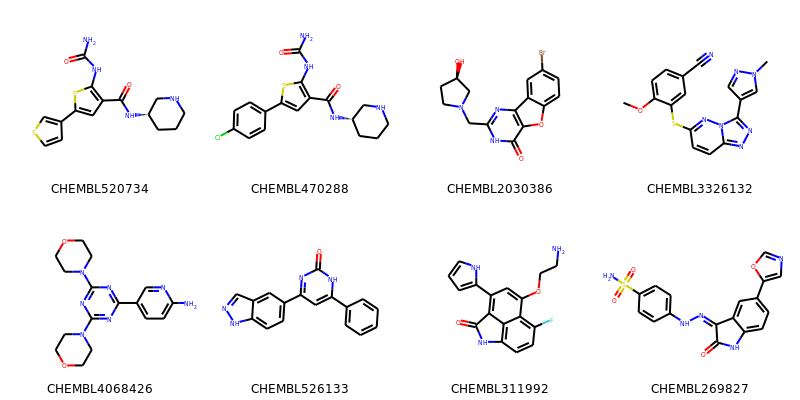

In [66]:
mols = []

for smiles in details_selected.smiles:
    mols.append(Chem.MolFromSmiles(smiles))
    
img = Draw.MolsToGridImage(mols, molsPerRow=4, legends=list(details_selected.chembl_id))
img

In [67]:
img.save('chembl_molecule_details/recomb_kinase_targets.pdf')

## Wrap-up

In [86]:
filtering

,filtering_step,molecules,targets,assays,values
0,ChEMBL bioactivity entries,33,46,65,69
1,Only human entries,24,33,46,48
2,"Only ""active"" entries",11,17,25,27
3,(Sanity check: Still the same after activity-target merge?),11,17,25,27
4,Only kinases,8,13,21,22


## Get all ATC classified molecules

In [87]:
# Check if first_approval field is not empty
details[details.first_approval == details.first_approval]

,atc_classification,chembl_id,first_approval,inchi,smiles


In [88]:
# Check if atc classified field is not empty
details[details.atc_classification.str.len() != 0]

,atc_classification,chembl_id,first_approval,inchi,smiles


## Get all approved drugs

In [89]:
approved_drugs = compound.filter(molecule_chembl_id__in = list(details.chembl_id), max_phase=4)

In [90]:
len(approved_drugs)

1

In [91]:
approved_mol = approved_drugs[0]

In [92]:
chembl_id = approved_mol['molecule_chembl_id']
chembl_id

'CHEMBL1909282'

In [93]:
mol = Chem.MolFromSmiles(
    details[details.chembl_id == chembl_id].smiles.values[0]
)

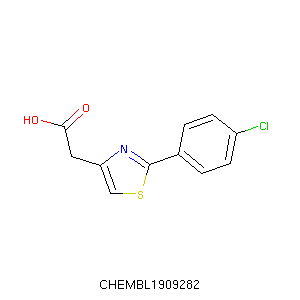

In [94]:
img = Draw.MolToImage(mol, legend=chembl_id)
img.save('chembl_molecule_details/recomb_approved_drug.png')
img

In [95]:
activities_approved_drugs = activity.filter(
    molecule_chembl_id = chembl_id,
    type = 'IC50',
    assay_type = 'B'
).only(
    'activity_id','assay_chembl_id', 'assay_description', 'assay_type', \
    'molecule_chembl_id', 'type', 'units', 'relation', 'value', \
    'target_chembl_id', 'target_organism'
)

In [96]:
activities_approved_drugs = pd.DataFrame.from_records(list(activities_approved_drugs))
activities_approved_drugs

,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,target_chembl_id,target_organism,type,units,value
0,15460367,CHEMBL3540574,Inhibition of Sprague-Dawley rat Bsep expressed in plasma membrane vesicles of Sf21 cells assessed as inhibition of ATP-dependent [3H]taurocholate uptake,B,CHEMBL1909282,>,CHEMBL2073674,Rattus norvegicus,IC50,uM,1000
1,15460435,CHEMBL3540573,Inhibition of human BSEP expressed in plasma membrane vesicles of Sf21 cells assessed as inhibition of ATP-dependent [3H]taurocholate uptake,B,CHEMBL1909282,>,CHEMBL6020,Homo sapiens,IC50,uM,1000


In [97]:
get_protein_target_classifications(activities_approved_drugs.target_chembl_id)

,l1,l2,l3,l4,l5,l6,l7,l8,protein_class_id,target_chembl_id,component_id,protein_classification_id
0,Transporter,Primary active transporter,ATP-binding cassette,ABCB subfamily,None,None,None,None,1132,CHEMBL2073674,5895,1132
1,Transporter,Primary active transporter,ATP-binding cassette,ABCB subfamily,None,None,None,None,1132,CHEMBL6020,4541,1132
